# CS 4820
# Assignment 11: Time Series and Recurrent Neural Networks (RNN)

In Tutorail 11, you successfully predicted the electric load of the next hour and now we would like to push it further. Let's see if your model (with the following changes) can predict the load __in 36 hours__ instead of the next hour.

- The entire section 1 "Time series forecasting" should stay the same between Tutorial 11 and this assignment.
- In section 2 "LSTM model" below, set the following before using the helper `function create_lagged_Xy_win` to generate new X and y pairs 
    - `start_lag=36`
    - `window_len=72`
- Still in section 2 "LSTM model" below, build an LSTM model of three layers
    - One LSTM layer of 12 LSTM units. Set `kernel_initializer='normal'`. Also, set `return_sequences=True` since there is another LSTM layer following this one.
    - Another LSTM layer of 6 LSTM units. Set `kernel_initializer='normal'`. No need to set `return_sequences=True` since this is the last LSTM layer.
    - One last layer of `Dense(1)`.
- Train, test, and evaluate your model like what you did in Tutorial 11.


### 1. Time series forecasting

Load and pre-process the data.

In [1]:
# allow multiple outputs be displayed for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Local Jupyter Notebook
fname = './data/ZonalDemands_2003-2016.csv.bz2'

df = pd.read_csv(fname, compression='bz2',
                 engine='python')

df.head(3)
df.tail(3)

,Date,Hour,Total Ontario,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Tot Zones,diff
119853,2016/12/31,22,15195,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,595
119854,2016/12/31,23,14758,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"1,032"
119855,2016/12/31,24,14153,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"1,637"


In [2]:
def combine_date_hour(row):
    date = pd.to_datetime(row['Date'])
    hour = pd.Timedelta("%d hours" % row['Hour'])
    return date + hour

idx = df.apply(combine_date_hour, axis=1)
idx.head()

0   2003-05-01 01:00:00
1   2003-05-01 02:00:00
2   2003-05-01 03:00:00
3   2003-05-01 04:00:00
4   2003-05-01 05:00:00
dtype: datetime64[ns]

In [3]:
df = df.set_index(idx)

df.head(3)
df.tail(3)

,Date,Hour,Total Ontario,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Tot Zones,diff
2003-05-01 01:00:00,01-May-03,1,13702,809,1284,965,765,4422,622,41,2729,617,1611,13865,163
2003-05-01 02:00:00,01-May-03,2,13578,825,1283,923,752,4340,602,43,2731,615,1564,13678,100
2003-05-01 03:00:00,01-May-03,3,13411,834,1277,910,751,4281,591,45,2696,596,1553,13534,123


,Date,Hour,Total Ontario,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Tot Zones,diff
2016-12-31 22:00:00,2016/12/31,22,15195,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,595
2016-12-31 23:00:00,2016/12/31,23,14758,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"1,032"
2017-01-01 00:00:00,2016/12/31,24,14153,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"1,637"


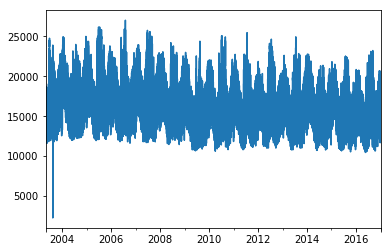

In [4]:
df['Total Ontario'].plot()

### Split

In [5]:
split_date = pd.Timestamp('01-01-2014')

train = df.loc[:split_date, ['Total Ontario']].copy()
test = df.loc[split_date:, ['Total Ontario']].copy()

train.head(3)
train.tail(3)

test.head(3)
test.tail(3)

,Total Ontario
2003-05-01 01:00:00,13702
2003-05-01 02:00:00,13578
2003-05-01 03:00:00,13411


,Total Ontario
2013-12-31 22:00:00,17572
2013-12-31 23:00:00,16966
2014-01-01 00:00:00,16385


,Total Ontario
2014-01-01 00:00:00,16385
2014-01-01 01:00:00,15862
2014-01-01 02:00:00,15462


,Total Ontario
2016-12-31 22:00:00,15195
2016-12-31 23:00:00,14758
2017-01-01 00:00:00,14153


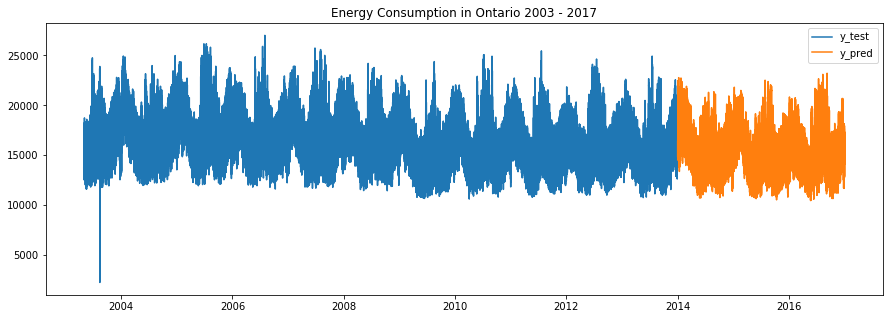

In [6]:
plt.figure(figsize=(15,5))
plt.plot(train, label='y_test')
plt.plot(test, label='y_pred')
plt.legend()
plt.title("Energy Consumption in Ontario 2003 - 2017");

In [7]:
offset = 10000
scale = 5000

train_sc = (train - offset) / scale
test_sc = (test - offset) / scale

train_sc[:4]

,Total Ontario
2003-05-01 01:00:00,0.7404
2003-05-01 02:00:00,0.7156
2003-05-01 03:00:00,0.6822
2003-05-01 04:00:00,0.7002


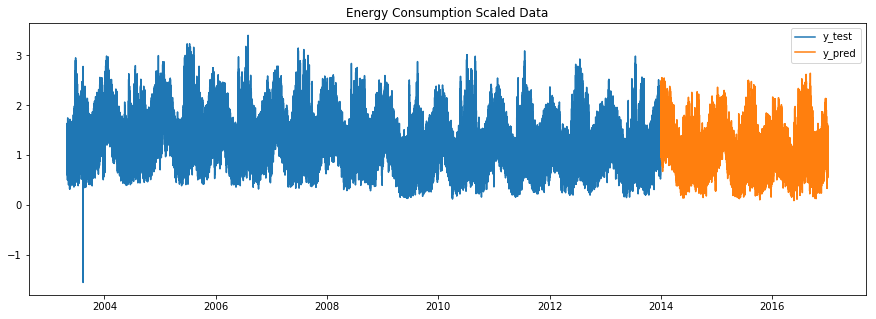

In [8]:
plt.figure(figsize=(15,5))
plt.plot(train_sc, label='y_test')
plt.plot(test_sc, label='y_pred')
plt.legend()
plt.title("Energy Consumption Scaled Data");

### Targets

In [9]:
X_train = train_sc[:-1].values
y_train = train_sc[1:].values


X_test = test_sc[:-1].values
y_test = test_sc[1:].values

X_train[:5]
y_train[:5]

array([[0.7404],
       [0.7156],
       [0.6822],
       [0.7002],
       [0.802 ]])

array([[0.7156],
       [0.6822],
       [0.7002],
       [0.802 ],
       [1.0226]])

### 2. Long Short Term Memory (LSTM) Neural Networks Model

#### 2.1 Rolling windows

In [10]:
window_len = 72

In [11]:
def create_lagged_Xy_win(data, start_lag=1,
                         window_len=1):
    X = data.shift(start_lag + window_len - 1).copy()
    X.columns = ['T_{}'.format(start_lag + window_len - 1)]

    if window_len > 1:
        for s in range(window_len, 0, -1):
            col_ = 'T_{}'.format(start_lag + s - 1)
            X[col_] = data.shift(start_lag + s - 1)

    X = X.dropna()
    idx = X.index
    y = data.loc[idx]
    return X, y

In [12]:
start_lag=36

X_train, y_train = create_lagged_Xy_win(train_sc,
                                        start_lag,
                                        window_len)

X_test, y_test = create_lagged_Xy_win(test_sc,
                                      start_lag,
                                      window_len)

X_train.head()
y_train.head()

,T_107,T_106,T_105,T_104,T_103,T_102,T_101,T_100,T_99,T_98,...,T_45,T_44,T_43,T_42,T_41,T_40,T_39,T_38,T_37,T_36
2003-05-05 12:00:00,0.7404,0.7156,0.6822,0.7002,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,...,1.0062,1.0262,1.0532,1.0188,0.9716,1.0562,1.1044,0.9856,0.8160,0.6738
2003-05-05 13:00:00,0.7156,0.6822,0.7002,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,1.6342,...,1.0262,1.0532,1.0188,0.9716,1.0562,1.1044,0.9856,0.8160,0.6738,0.5882
2003-05-05 14:00:00,0.6822,0.7002,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,1.6342,1.6242,...,1.0532,1.0188,0.9716,1.0562,1.1044,0.9856,0.8160,0.6738,0.5882,0.5338
2003-05-05 15:00:00,0.7002,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,1.6342,1.6242,1.6236,...,1.0188,0.9716,1.0562,1.1044,0.9856,0.8160,0.6738,0.5882,0.5338,0.5058
2003-05-05 16:00:00,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,1.6342,1.6242,1.6236,1.5976,...,0.9716,1.0562,1.1044,0.9856,0.8160,0.6738,0.5882,0.5338,0.5058,0.5048


,Total Ontario
2003-05-05 12:00:00,1.6502
2003-05-05 13:00:00,1.6526
2003-05-05 14:00:00,1.6590
2003-05-05 15:00:00,1.6726
2003-05-05 16:00:00,1.7468


In [13]:
X_train_t = X_train.values.reshape(-1, window_len, 1)
X_test_t = X_test.values.reshape(-1, window_len, 1)

y_train_t = y_train.values
y_test_t = y_test.values

X_train_t.shape

(93445, 72, 1)

#### 2.2 Model construction

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense

K.clear_session()

In [25]:
model = Sequential()
model.add(LSTM(12, kernel_initializer='normal', 
               input_shape=(window_len, 1), return_sequences=True))
model.add(LSTM(6, kernel_initializer='normal'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0005) )

In [26]:
model.fit(X_train_t, y_train_t,
          epochs=10,
          batch_size=256,
          verbose=1);

Epoch 1/10
93445/93445 [==============================] - 16s 167us/sample - loss: 0.4822
Epoch 2/10
93445/93445 [==============================] - 17s 182us/sample - loss: 0.1364
Epoch 3/10
93445/93445 [==============================] - 17s 182us/sample - loss: 0.1167
Epoch 4/10
93445/93445 [==============================] - 17s 177us/sample - loss: 0.1126
Epoch 5/10
93445/93445 [==============================] - 18s 194us/sample - loss: 0.1103
Epoch 6/10
93445/93445 [==============================] - 17s 182us/sample - loss: 0.1083
Epoch 7/10
93445/93445 [==============================] - 16s 171us/sample - loss: 0.1057 - loss: 0
Epoch 8/10
93445/93445 [==============================] - 16s 169us/sample - loss: 0.1049
Epoch 9/10
93445/93445 [==============================] - 16s 167us/sample - loss: 0.1038
Epoch 10/10
93445/93445 [==============================] - 16s 169us/sample - loss: 0.1024


#### 2.3 Model evaluation

For your reference, the following is a small part of my predictive model to compare train and test.

![LSTM 36 hours](./assets/LSTM_36_hours.png)

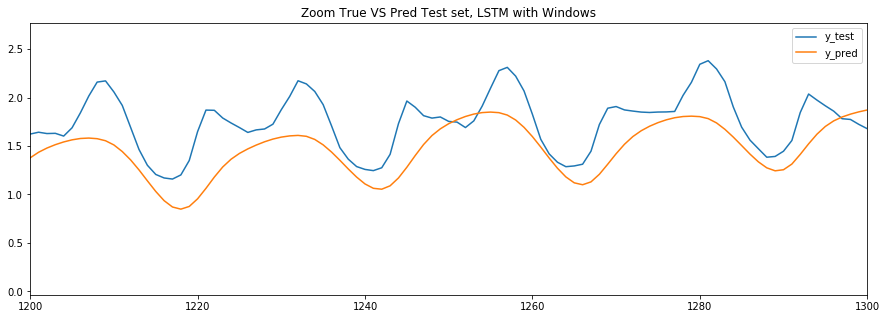

In [27]:
y_pred = model.predict(X_test_t, batch_size=256)
plt.figure(figsize=(15,5))
plt.plot(y_test_t, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1200,1300)
plt.title("Zoom True VS Pred Test set, LSTM with Windows");

In [28]:
y_test_s = pd.Series(y_test_t.ravel())
y_pred_s = pd.Series(y_pred.ravel())

for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.32
Shift: -4, Corr: 0.47
Shift: -3, Corr: 0.61
Shift: -2, Corr: 0.71
Shift: -1, Corr: 0.77
Shift:  0, Corr: 0.78
Shift:  1, Corr: 0.75
Shift:  2, Corr: 0.68
Shift:  3, Corr: 0.57
Shift:  4, Corr: 0.45
